In [1]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.aformer_atac_cage as aformer
#import src.aformer_TF as aformer
from src.layers.layers import *
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers
import src.utils as utils

import training_utils_atac_cage as training_utils


from scipy import stats

2023-02-14 21:32:20.248154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 21:32:20.414048: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 21:32:20.414081: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-14 21:32:21.338424: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-6')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    #options.experimental_threading.max_intra_op_parallelism = 1
    mixed_precision.set_global_policy('mixed_bfloat16')
    tf.config.optimizer.set_jit(True)
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 1
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

2023-02-14 21:32:22.768023: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-14 21:32:22.768075: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-14 21:32:22.768099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-genformer-v2-6): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2023-02-14 21:32:23.078141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 21:32:23.190667: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:447] Started server with target: grpc://localhost:45945
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: node-6


INFO:tensorflow:Initializing the TPU system: node-6


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
g = tf.random.Generator.from_seed(datetime.now().timestamp())
with strategy.scope():
    
    data_tr,data_val,data_val_TSS = training_utils.return_distributed_iterators("gs://picard-testing-176520/genformer_atac_rampage_globalacc_conv/preprocessed",
                                                                                "gs://picard-testing-176520/genformer_atac_rampage_globalacc_conv_TSS/preprocessed",
                                                                               GLOBAL_BATCH_SIZE,
                                                                               196608,
                                                                               10, 
                                                                               1536,
                                                                               320,
                                                                               128,
                                                                               8,
                                                                               50,
                                                                               strategy,
                                                                               options,
                                                                                "True",
                                                                               g)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
with strategy.scope():
    inits = training_utils.get_initializers_enformer_performer("gs://picard-testing-176520/aformer_baseline/aformer_baseline_196k_load-True_frz-True_LR1-1e-06_LR2-7.5e-05_LR3-0.0001_T-4_F-1552_D-0.05_K-relu_kernel_transformation_2023-01-29_15:26:49/iteration_40",
                                                              4)
    #inits = training_utils.get_initializers_enformer_conv("/home/jupyter/dev/BE_CD69_paper_2022/enformer_fine_tuning/checkpoint/sonnet_weights")
    model = aformer.aformer(kernel_transformation = 'relu_kernel_transformation',
                            dropout_rate = 0.05,
                            pointwise_dropout_rate=0.15,
                            input_length = 196608,
                            output_length = 1536,
                            final_output_length = 896,
                             num_heads = 8,
                             numerical_stabilizer = 0.001,
                             nb_random_features = 256,
                             hidden_size = 1552,
                             num_transformer_layers = 4,
                             d_model = 1552,
                             norm=True,
                             dim = 194, 
                            BN_momentum=0.90,
                             max_seq_length = 1536,
                             use_rot_emb = True,
                             use_mask_pos = False, 
                             normalize = True,
                             seed = 3,
                             load_init=True,
                             inits=inits,
                            freeze_conv_layers=True,
                            inits_type='enformer_performer')

True


In [5]:
with strategy.scope():
    optimizer1 = tfa.optimizers.AdaBelief(
        learning_rate= 1.0e-06,
        epsilon= 1.0e-14,
        weight_decay= 0.0,
        rectify=True,
        total_steps= 10000,
        warmup_proportion= 0.01,
        min_lr= 1.0e-07
    )
    optimizer2 = tfa.optimizers.AdaBelief(
        learning_rate= 1.0e-04,
        epsilon= 1.0e-14,
        weight_decay= 0.0,
        rectify=True,
        total_steps= 10000,
        warmup_proportion= 0.01,
        min_lr= 1.0e-05
    )
    
    optimizers_in=optimizer1,optimizer2
    

In [6]:
with strategy.scope():
    metric_dict = {}
    train_step, val_step, val_step_TSS, build_step, metric_dict = training_utils.return_train_val_functions(model,
                                                                                                             100,
                                                                                                             40,
                                                                                                             40,
                                                                                                              optimizers_in,
                                                                                                              strategy,
                                                                                                              metric_dict,
                                                                                                              GLOBAL_BATCH_SIZE,
                                                                                                            5.0,
                                                                                                              10.0,
                                                                                                              "True")


total params: tf.Tensor(82056530, shape=(), dtype=int32)
hg_train_loss: 1.8457541
hg_val_loss: 0.9171497
hg_val_cage_pearson: [0.08687144]
hg_val_cage_R2: [7.3969364e-05]
hg_val_atac_pearson: [0.5477635]
hg_val_atac_R2: [0.04649752]
hg_val_atac_baseline_pearson: [0.8357922]
hg_val_atac_baseline_R2: [0.6754675]
cell spec corr: 0.37993834627505074
gene_spec_corr:0.03445392843264175
completed epoch 1
duration(mins): 5.597492857774099
patience counter at: 0
hg_train_loss: 0.18353245
hg_val_loss: 0.6397196
hg_val_cage_pearson: [0.13143411]
hg_val_cage_R2: [0.00271344]
hg_val_atac_pearson: [0.5218392]
hg_val_atac_R2: [0.07186711]
hg_val_atac_baseline_pearson: [0.8367869]
hg_val_atac_baseline_R2: [0.67934513]
cell spec corr: 0.636769736615096
gene_spec_corr:0.18838482877696935
completed epoch 2
duration(mins): 4.744288432598114
patience counter at: 0
hg_train_loss: -0.19915976
hg_val_loss: -1.1826777
hg_val_cage_pearson: [0.14980887]
hg_val_cage_R2: [0.00604272]
hg_val_atac_pearson: [0.384916

/home/jupyter/dev/aformer/training_utils_atac_cage.py:1066: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_cell_spec,ax_cell_spec=plt.subplots(figsize=(6,6))


cell spec corr: 0.602690474322703
gene_spec_corr:0.33585334308431725
completed epoch 7
duration(mins): 4.867458069324494
patience counter at: 0
hg_train_loss: -0.71691245
hg_val_loss: -1.8598328
hg_val_cage_pearson: [0.23072207]
hg_val_cage_R2: [0.02519572]
hg_val_atac_pearson: [0.6984496]
hg_val_atac_R2: [0.4813795]
hg_val_atac_baseline_pearson: [0.81713605]
hg_val_atac_baseline_R2: [0.65076137]
cell spec corr: 0.6205324233613114
gene_spec_corr:0.5380327656630285
completed epoch 8
duration(mins): 4.884364112218221
patience counter at: 0
hg_train_loss: -0.38577792
hg_val_loss: -0.68701166
hg_val_cage_pearson: [0.42001563]
hg_val_cage_R2: [0.03248507]
hg_val_atac_pearson: [0.6740137]
hg_val_atac_R2: [0.3149373]
hg_val_atac_baseline_pearson: [0.81566304]
hg_val_atac_baseline_R2: [0.64119726]
cell spec corr: 0.5943242953543949
gene_spec_corr:0.2771559424602119
completed epoch 9
duration(mins): 4.905070960521698
patience counter at: 0


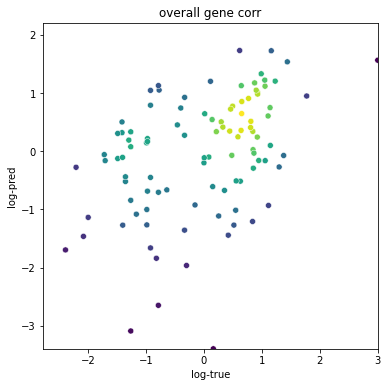

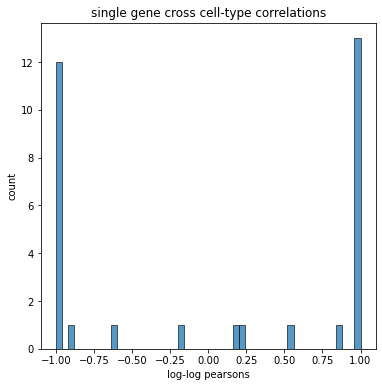

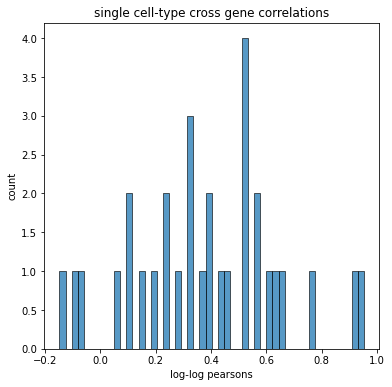

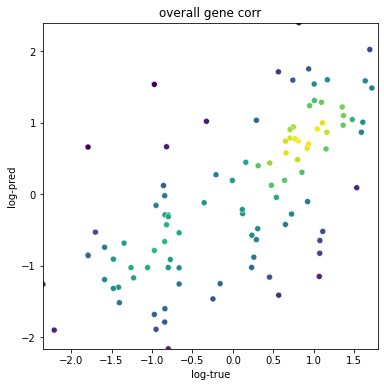

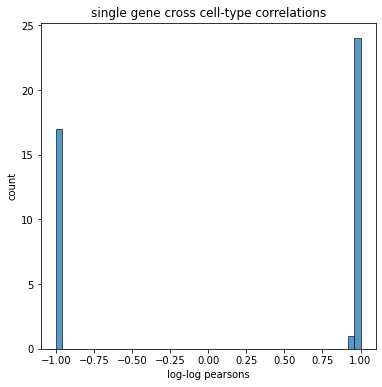

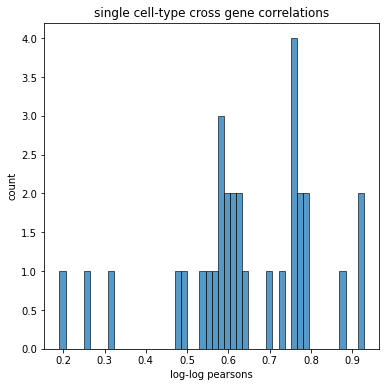

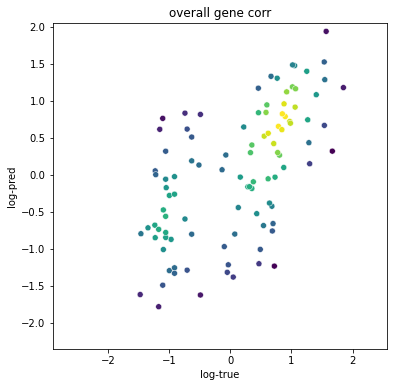

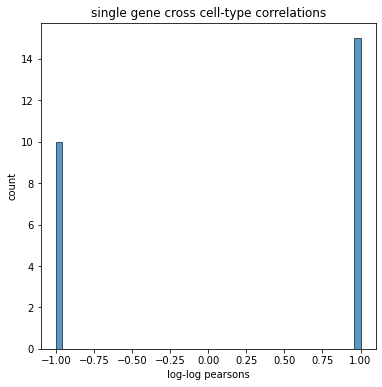

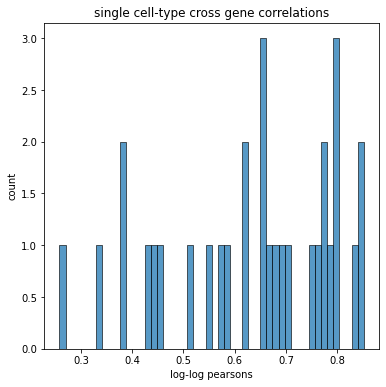

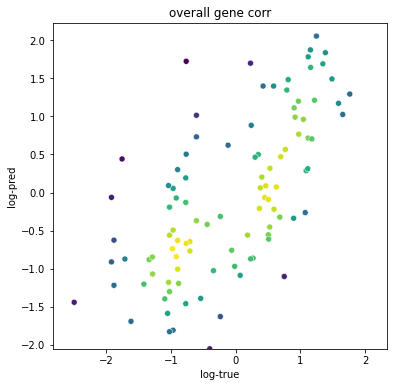

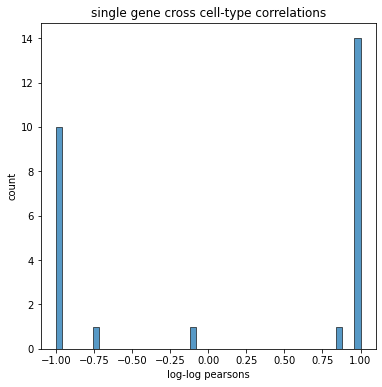

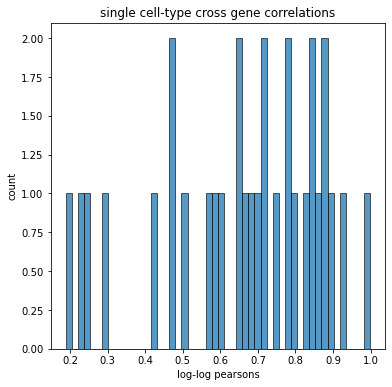

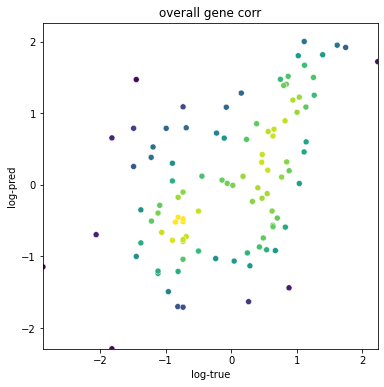

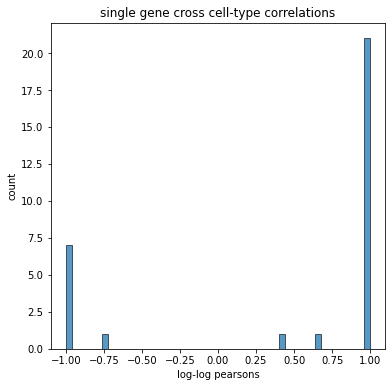

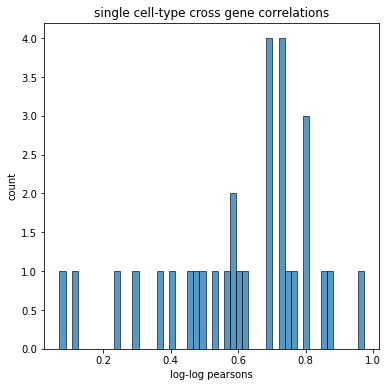

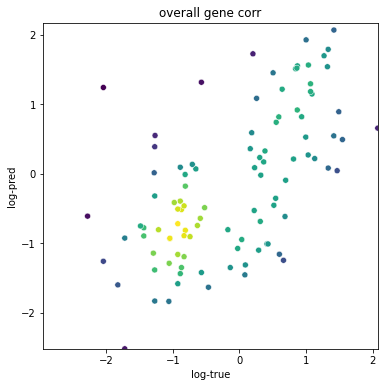

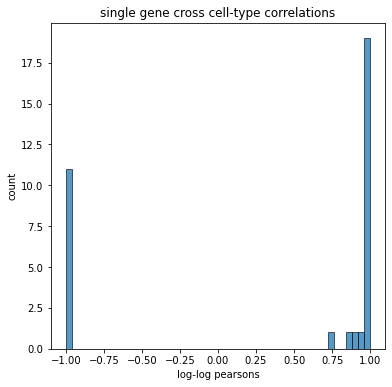

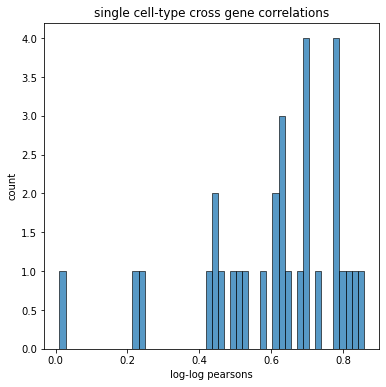

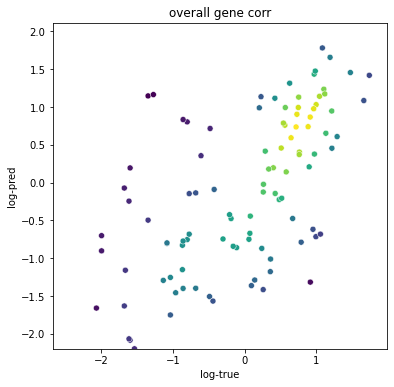

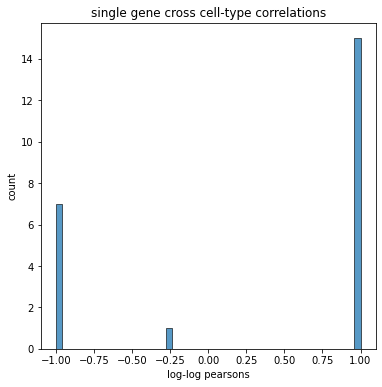

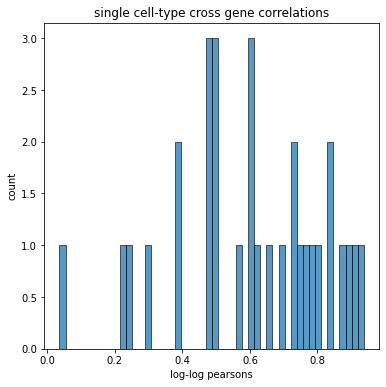

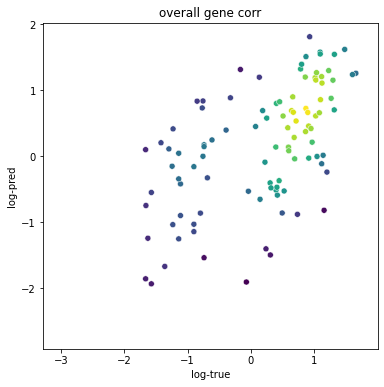

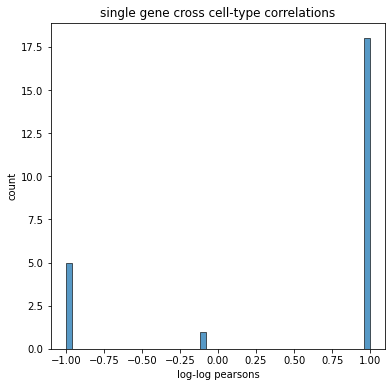

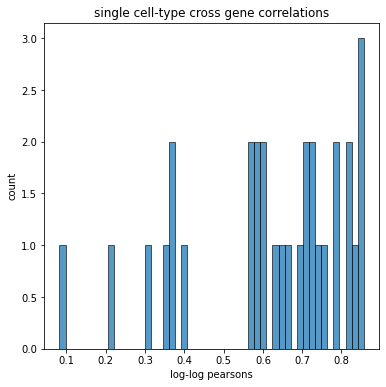

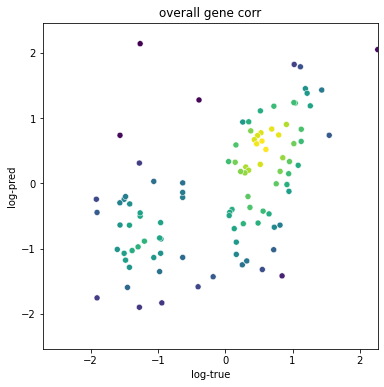

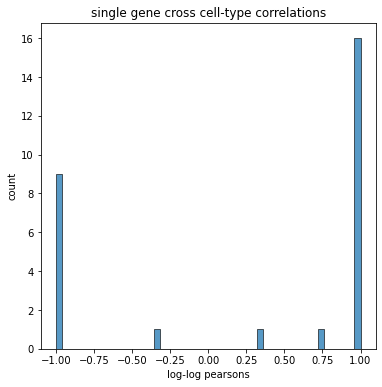

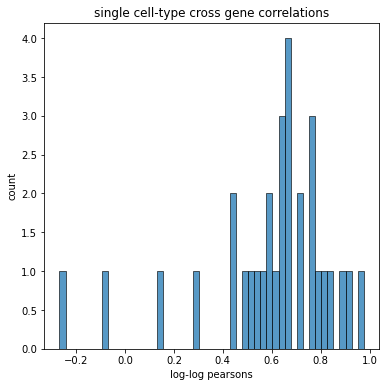

In [7]:
from scipy.stats.stats import pearsonr  
with strategy.scope():
    def sum_log(x):
        return np.log10(1.0 + np.nansum(x))
    
    global_step = 0
    val_losses = []
    val_pearsons = []
    val_R2 = []
    patience_counter = 0
    stop_criteria = False
    best_epoch = 0

    for epoch_i in range(1, 10):
        start = time.time()
        if epoch_i == 1:
            build_step(data_val)
            total_params = 0
            for k in model.trainable_variables:
                var = k.values[0]
                total_params += tf.size(var)
            print('total params: ' + str(total_params))

        train_step(data_tr)

        print('hg_train_loss: ' + str(metric_dict['train_loss'].result().numpy()))
        
        val_step(data_val)

        val_losses.append(metric_dict['val_loss'].result().numpy())
        print('hg_val_loss: ' + str(metric_dict['val_loss'].result().numpy()))
        print('hg_val_cage_pearson: ' + str(metric_dict['CAGE_PearsonR'].result()['PearsonR'].numpy()))
        print('hg_val_cage_R2: ' + str(metric_dict['CAGE_R2'].result()['R2'].numpy()))
        
        print('hg_val_atac_pearson: ' + str(metric_dict['ATAC_PearsonR'].result()['PearsonR'].numpy()))
        print('hg_val_atac_R2: ' + str(metric_dict['ATAC_R2'].result()['R2'].numpy()))
        
        
        print('hg_val_atac_baseline_pearson: ' + str(metric_dict['ATAC_PearsonR_baseline'].result()['PearsonR'].numpy()))
        print('hg_val_atac_baseline_R2: ' + str(metric_dict['ATAC_R2_baseline'].result()['R2'].numpy()))
        
        val_step_TSS(data_val_TSS)
        
        y_trues = metric_dict['corr_stats'].result()['y_trues'].numpy()
        y_preds = metric_dict['corr_stats'].result()['y_preds'].numpy()
        cell_types = metric_dict['corr_stats'].result()['cell_types'].numpy()
        gene_map = metric_dict['corr_stats'].result()['gene_map'].numpy()


        figures, corrs_overall = training_utils.make_plots(y_trues,
                                           y_preds, 
                                           cell_types, 
                                           gene_map)
        
        cell_spec,gene_spec = corrs_overall
        
        print('cell spec corr: ' + str(cell_spec))
        print('gene_spec_corr:' + str(gene_spec))
        

        end = time.time()
        duration = (end - start) / 60.
        print('completed epoch ' + str(epoch_i))
        print('duration(mins): ' + str(duration))
        print('patience counter at: ' + str(patience_counter))
        
        for key, item in metric_dict.items():
            item.reset_state()
        

In [8]:
inits = training_utils.get_initializers_enformer_performer("gs://picard-testing-176520/enformer_performer_FULL_atac_mean/models/enformer_performer_FULL_atac_mean_196k_load_init-True_freeze-True_LR1-1e-06_LR2-7.5e-05_T-6_F-1536_D-0.4_K-relu_kernel_transformation_AD-0.05/iteration_30",
                                                           6)
print(len(inits))

175


In [9]:



path = "gs://picard-testing-176520/enformer_performer_FULL_atac_mean/models/enformer_performer_FULL_atac_mean_196k_load_init-True_freeze-True_LR1-1e-06_LR2-7.5e-05_T-6_F-1536_D-0.4_K-relu_kernel_transformation_AD-0.05/iteration_30"


inside_checkpoint=tf.train.list_variables(tf.train.latest_checkpoint(path))
reader = tf.train.load_checkpoint(path)

In [10]:
inside_checkpoint

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/beta/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/gamma/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [5, 768, 768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-1/_layer/layer_with_weights-0/beta/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-1/_layer/layer_with_weig

In [8]:
test

{'sequence': PerReplica:{
   0: <tf.Tensor: shape=(1, 196608, 4), dtype=float32, numpy=
 array([[[0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]]], dtype=float32)>,
   1: <tf.Tensor: shape=(1, 196608, 4), dtype=float32, numpy=
 array([[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.]]], dtype=float32)>,
   2: <tf.Tensor: shape=(1, 196608, 4), dtype=float32, numpy=
 array([[[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]], dtype=float32)>,
   3: <tf.Tensor: shape=(1, 196608, 4), dtype=float32, numpy=
 array([[[1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 0., 0

In [17]:
test = tf.zeros([1,50,1])
test1 = tf.ones([1,50,1])
cat = tf.concat([test,test1],axis=2)
cat[:,:,0:1]

<tf.Tensor: shape=(1, 50, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]], dtype=float32)>

In [14]:
inside_checkpoint

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/beta/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/gamma/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [5, 768, 768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-1/_layer/layer_with_weights-0/beta/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-1/_layer/layer_with_weig